# NHIS Adult Summary Health Statistics — Access-to-Care Analysis

This notebook analyses the CDC's National Health Interview Survey (NHIS) dataset to
uncover patterns, inequities, and trends in healthcare access for U.S. adults aged 18+.

In [1]:
# ── Cell 1: Imports & Config ──────────────────────────────────────────────────
import warnings, textwrap, re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore", category=FutureWarning)

# Matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "savefig.bbox": "tight",
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})
plt.style.use("seaborn-v0_8-whitegrid")

# Output directories
FIGURES = Path("figures")
FIGURES.mkdir(exist_ok=True)
REPORT = Path("report")
REPORT.mkdir(exist_ok=True)

print("Setup complete.")

Setup complete.


## Cell 2 — Load & Normalize

In [2]:
# ── Cell 2: Load & Normalize ──────────────────────────────────────────────────
KEEP_COLS = [
    "TOPIC", "SUBTOPIC", "TAXONOMY", "CLASSIFICATION",
    "GROUP", "SUBGROUP", "TIME_PERIOD",
    "ESTIMATE", "STANDARD_ERROR", "ESTIMATE_LCI", "ESTIMATE_UCI",
    "FLAG", "ESTIMATE_TYPE",
]

raw = pd.read_csv("Access_to_Care_Dataset.csv")

# Keep only the columns we need
df_all = raw[[c for c in KEEP_COLS if c in raw.columns]].copy()

# Strip whitespace from string columns
str_cols = df_all.select_dtypes(include="object").columns
for c in str_cols:
    df_all[c] = df_all[c].astype(str).str.strip().replace({"nan": np.nan, "": np.nan})

# Coerce numeric columns
for c in ["ESTIMATE", "STANDARD_ERROR", "ESTIMATE_LCI", "ESTIMATE_UCI"]:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

# TIME_PERIOD → int
df_all["TIME_PERIOD"] = pd.to_numeric(df_all["TIME_PERIOD"], errors="coerce").astype("Int64")

# ── Build derivative DataFrames ──────────────────────────────────────────────
df_numeric = df_all.dropna(subset=["ESTIMATE"]).copy()

has_se = df_numeric["STANDARD_ERROR"].notna()
has_ci = df_numeric["ESTIMATE_LCI"].notna() & df_numeric["ESTIMATE_UCI"].notna()
df_clean = df_numeric[has_se | has_ci].copy()

# Defensively exclude flagged rows (FLAG is empty for every row in this dataset)
df_clean = df_clean[df_clean["FLAG"].isna()].copy()

print(f"df_all    : {df_all.shape}")
print(f"df_numeric: {df_numeric.shape}")
print(f"df_clean  : {df_clean.shape}")
df_clean.head(3)

df_all    : (26208, 13)
df_numeric: (23839, 13)
df_clean  : (23609, 13)


,TOPIC,SUBTOPIC,TAXONOMY,CLASSIFICATION,GROUP,SUBGROUP,TIME_PERIOD,ESTIMATE,STANDARD_ERROR,ESTIMATE_LCI,ESTIMATE_UCI,FLAG,ESTIMATE_TYPE
0,Angina/angina pectoris,NaN,Cardiovascular diseases,Total,Total,18 years and older,2019,1.7,NaN,1.5,1.9,NaN,"Percent of population, crude"
1,Angina/angina pectoris,NaN,Cardiovascular diseases,Total,Total,18 years and older,2020,1.5,NaN,1.3,1.6,NaN,"Percent of population, crude"
2,Angina/angina pectoris,NaN,Cardiovascular diseases,Total,Total,18 years and older,2021,1.5,NaN,1.4,1.7,NaN,"Percent of population, crude"


## Cell 3 — Derive SE & Classify Rows (access barrier vs condition prevalence)

In [3]:
# ── Cell 3: Derive SE & Classify Rows ────────────────────────────────────────
# SE: prefer STANDARD_ERROR when present, else derive from CI
df_clean["se"] = df_clean["STANDARD_ERROR"].where(
    df_clean["STANDARD_ERROR"].notna(),
    (df_clean["ESTIMATE_UCI"] - df_clean["ESTIMATE_LCI"]) / (2 * 1.96),
)

# Build combined text field for keyword classification
_fill = lambda s: s.fillna("")
combined = (
    _fill(df_clean["TOPIC"]) + " " +
    _fill(df_clean["SUBTOPIC"]) + " " +
    _fill(df_clean["TAXONOMY"]) + " " +
    _fill(df_clean["ESTIMATE_TYPE"])
).str.lower()

ACCESS_KEYWORDS = [
    "delay", "did not get", "unmet", "cost", "afford",
    "uninsured", "usual place of care",
    "healthcare access and quality", "health insurance",
]

pattern = "|".join(ACCESS_KEYWORDS)
df_clean["row_type"] = np.where(
    combined.str.contains(pattern, case=False, na=False),
    "access_barrier",
    "condition_prevalence",
)

print("Row-type counts:")
print(df_clean["row_type"].value_counts())
print()

df_access = df_clean[df_clean["row_type"] == "access_barrier"].copy()
print(f"df_access shape: {df_access.shape}")
print(f"Unique access topics: {df_access['TOPIC'].nunique()}")
print(df_access["TOPIC"].value_counts())

Row-type counts:
row_type
condition_prevalence    18992
access_barrier           4617
Name: count, dtype: int64

df_access shape: (4617, 15)
Unique access topics: 11
TOPIC
Has a usual place of care among adults                                 458
Delayed getting medical care due to cost among adults                  454
Did not get needed medical care due to cost                            453
Did not take medication as prescribed to save money                    451
Did not get needed mental health care due to cost                      445
Uninsured for at least part of the past year among adults              413
Public health insurance coverage at time of interview among adults     406
Private health insurance coverage at time of interview among adults    393
Uninsured at time of interview among adults                            391
Uninsured for more than one year among adults                          380
Exchange-based coverage at time of interview among adults              373
Nam

## Cell 4 — Select Top Access Measures

In [4]:
# ── Cell 4: Select Top Access Measures ────────────────────────────────────────
measure_counts = (
    df_access
    .groupby(["TOPIC", "SUBTOPIC", "ESTIMATE_TYPE"], dropna=False)
    .size()
    .reset_index(name="n_rows")
    .sort_values("n_rows", ascending=False)
)

# Pick the top 4 measures (or fewer if < 4 exist)
N_MEASURES = min(4, len(measure_counts))
top_measures = measure_counts.head(N_MEASURES)
selected_measures = list(
    top_measures[["TOPIC", "SUBTOPIC", "ESTIMATE_TYPE"]].itertuples(index=False, name=None)
)

print(f"Selected {N_MEASURES} access measures:\n")
for i, (topic, subtopic, etype) in enumerate(selected_measures, 1):
    n = top_measures.iloc[i - 1]["n_rows"]
    label = topic if pd.isna(subtopic) else f"{topic} / {subtopic}"
    print(f"  {i}. {label}  ({etype})  — {n} rows")

Selected 4 access measures:

  1. Has a usual place of care among adults  (Percent of population, crude)  — 458 rows
  2. Delayed getting medical care due to cost among adults  (Percent of population, crude)  — 454 rows
  3. Did not get needed medical care due to cost  (Percent of population, crude)  — 453 rows
  4. Did not take medication as prescribed to save money  (Percent of population, crude)  — 451 rows


## Cell 5 — Per-Measure Visualizations

For each selected measure we produce three plots:
1. **Total trend line** with 95 % CI band
2. **Top subgroups** in the latest year (horizontal bar chart with error bars)
3. **Spread distribution** — box-plots of estimates across subgroups for each year


Has a usual place of care among adults


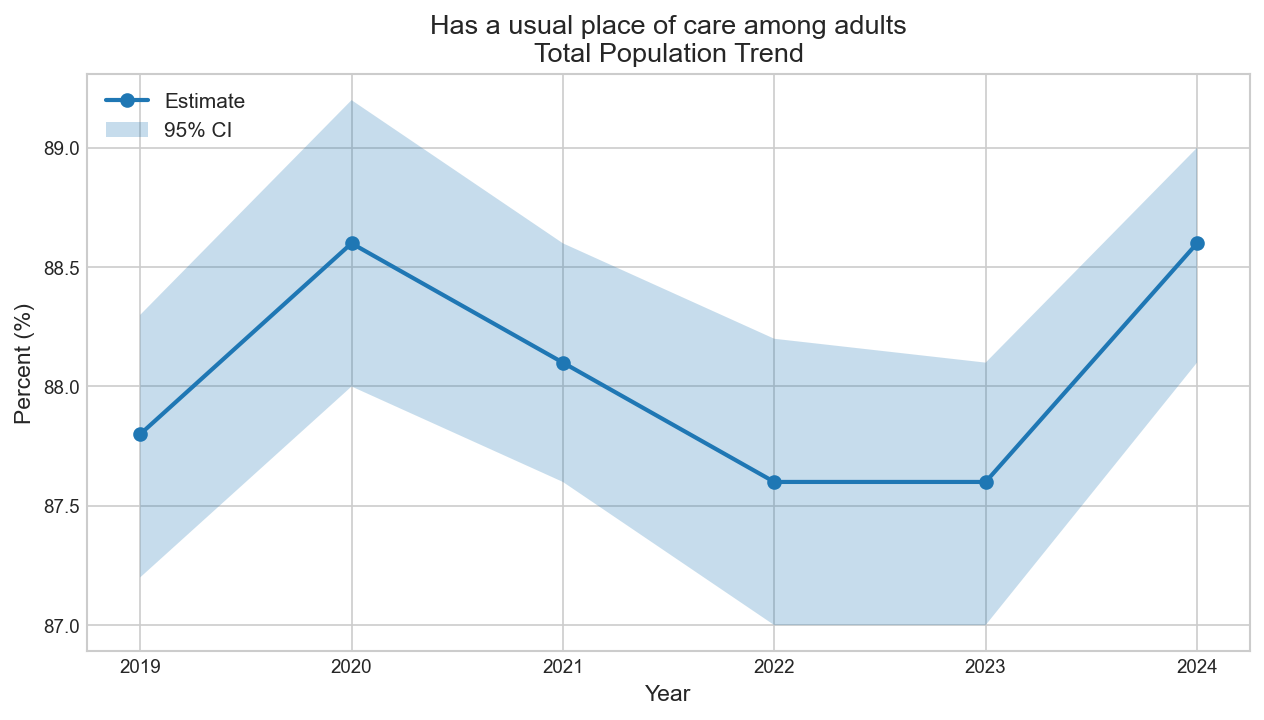

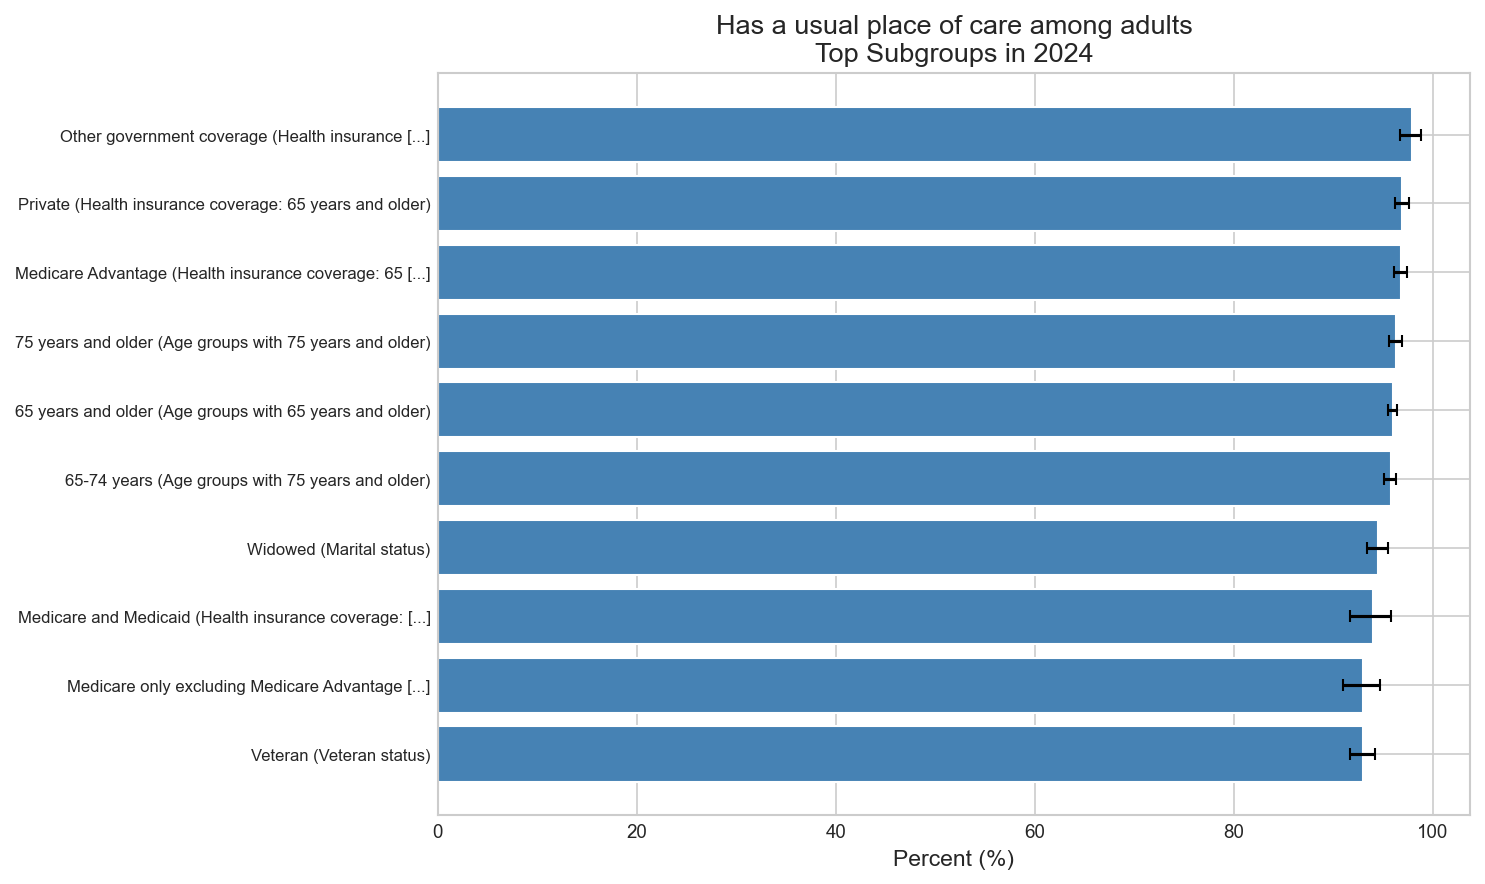

/var/folders/x2/3jft75dx3fn8xvn3p5vpdr3c0000gn/T/ipykernel_89955/2874379171.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_year, labels=[str(y) for y in years], patch_artist=True)


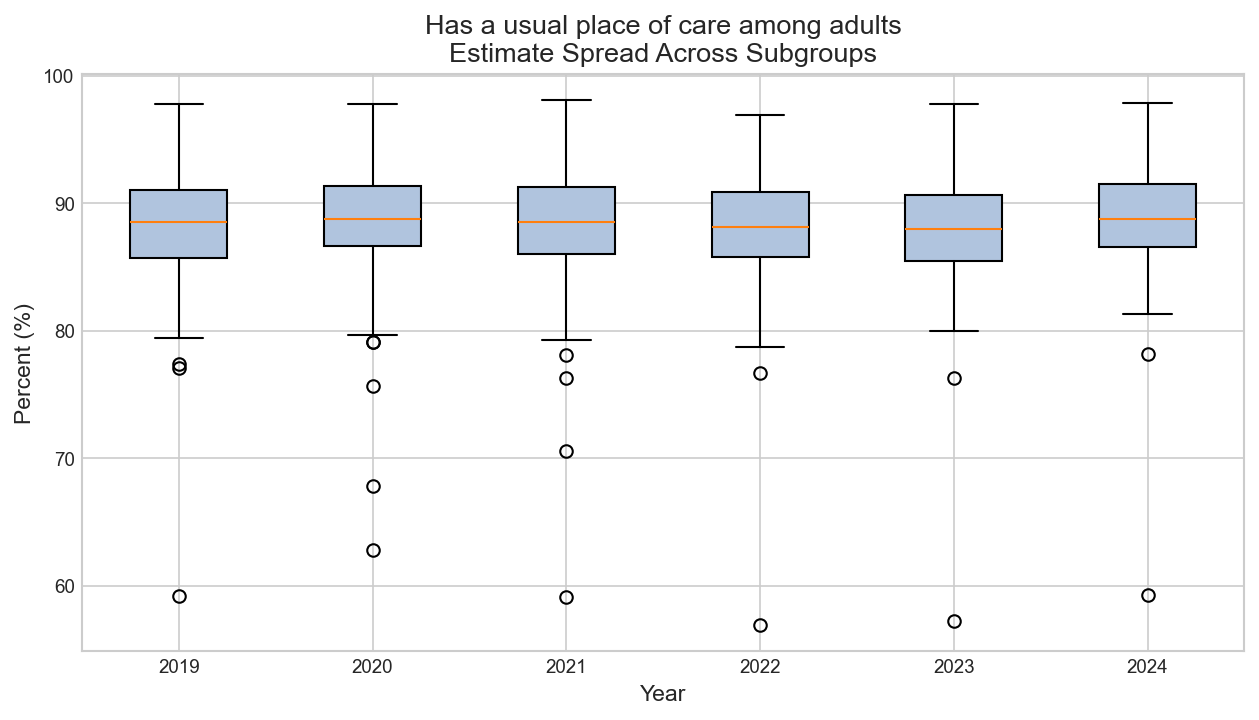


Delayed getting medical care due to cost among adults


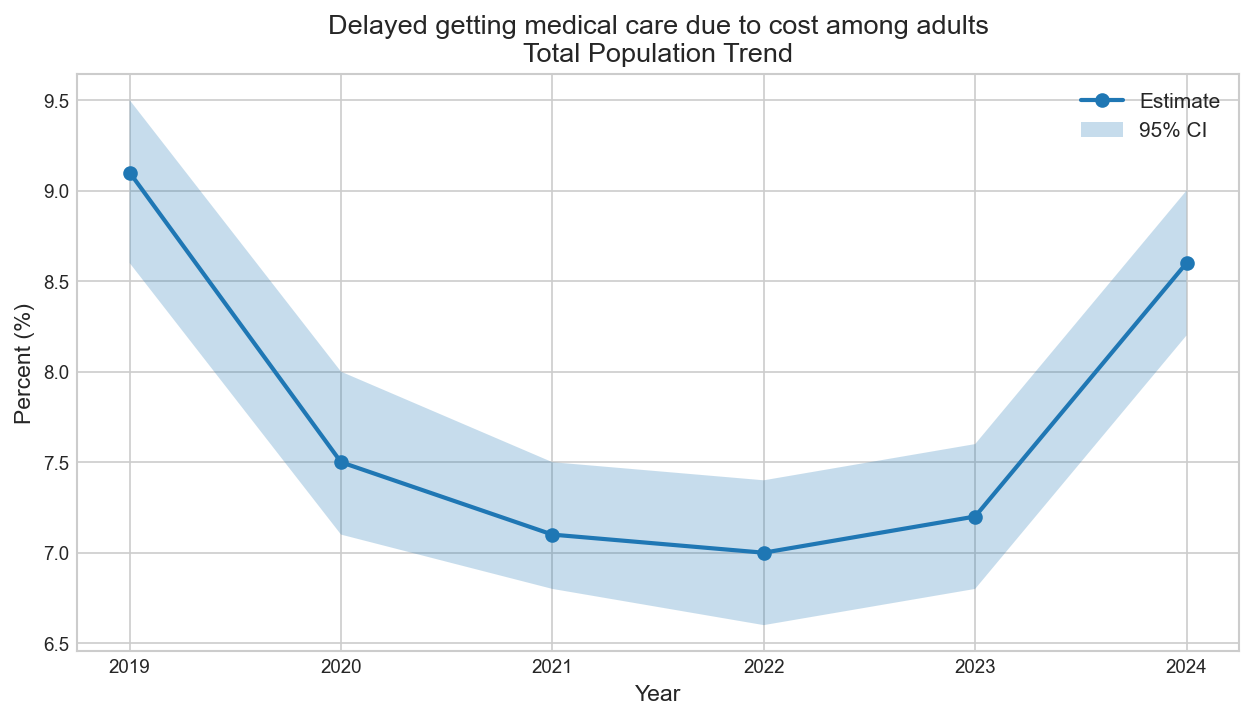

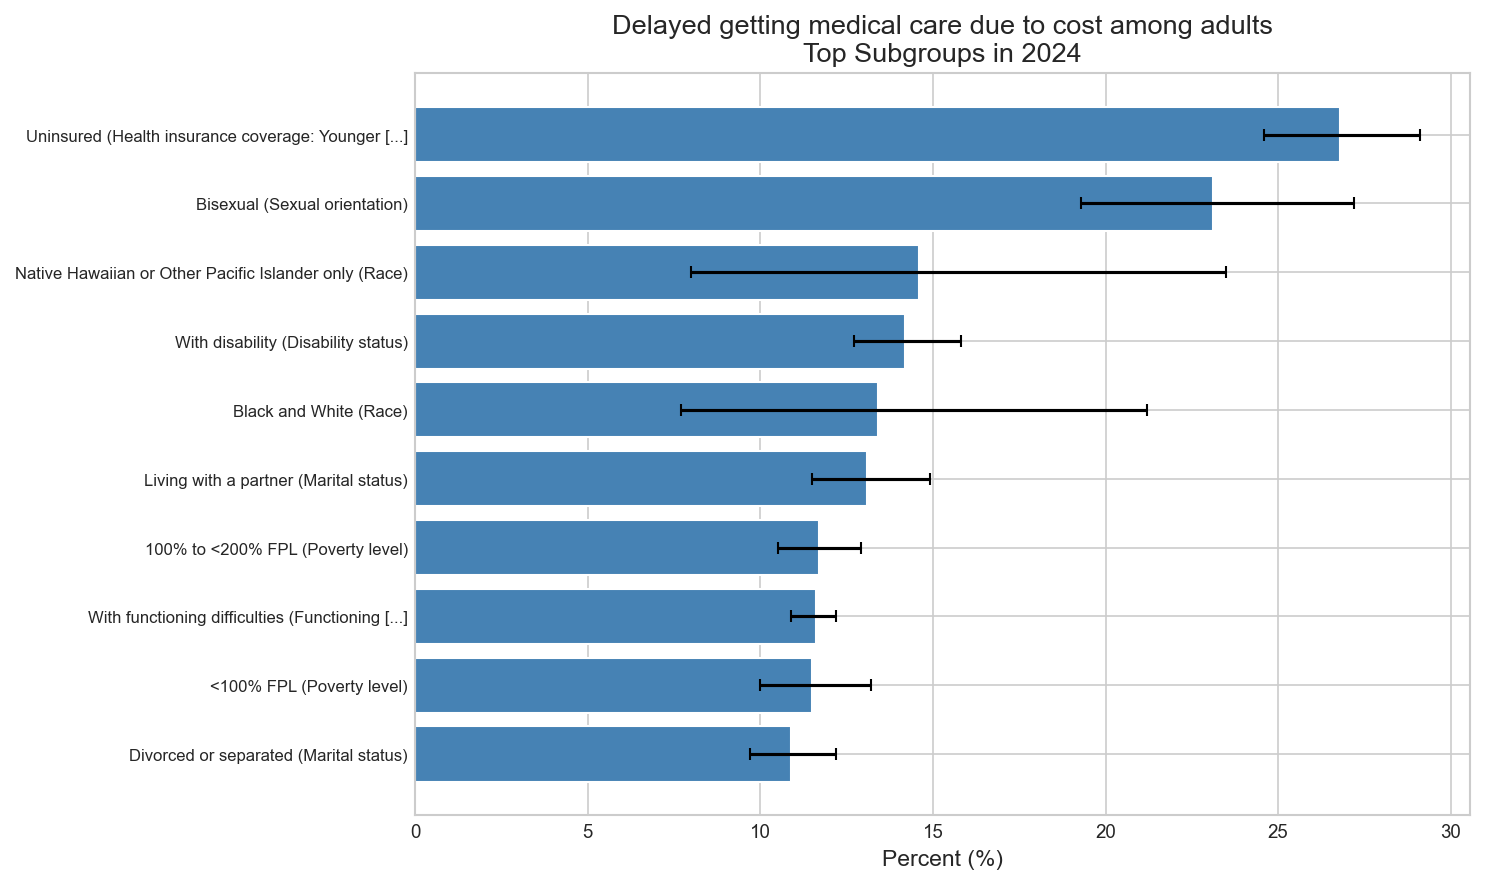

/var/folders/x2/3jft75dx3fn8xvn3p5vpdr3c0000gn/T/ipykernel_89955/2874379171.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_year, labels=[str(y) for y in years], patch_artist=True)


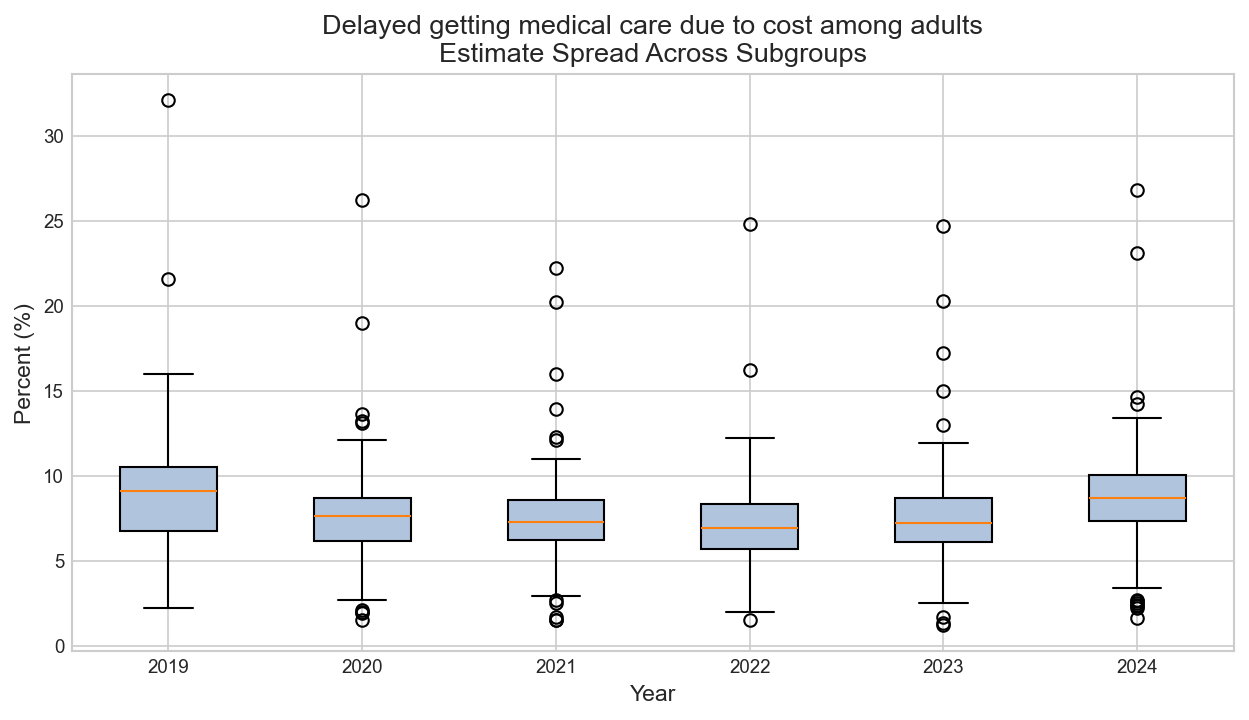


Did not get needed medical care due to cost


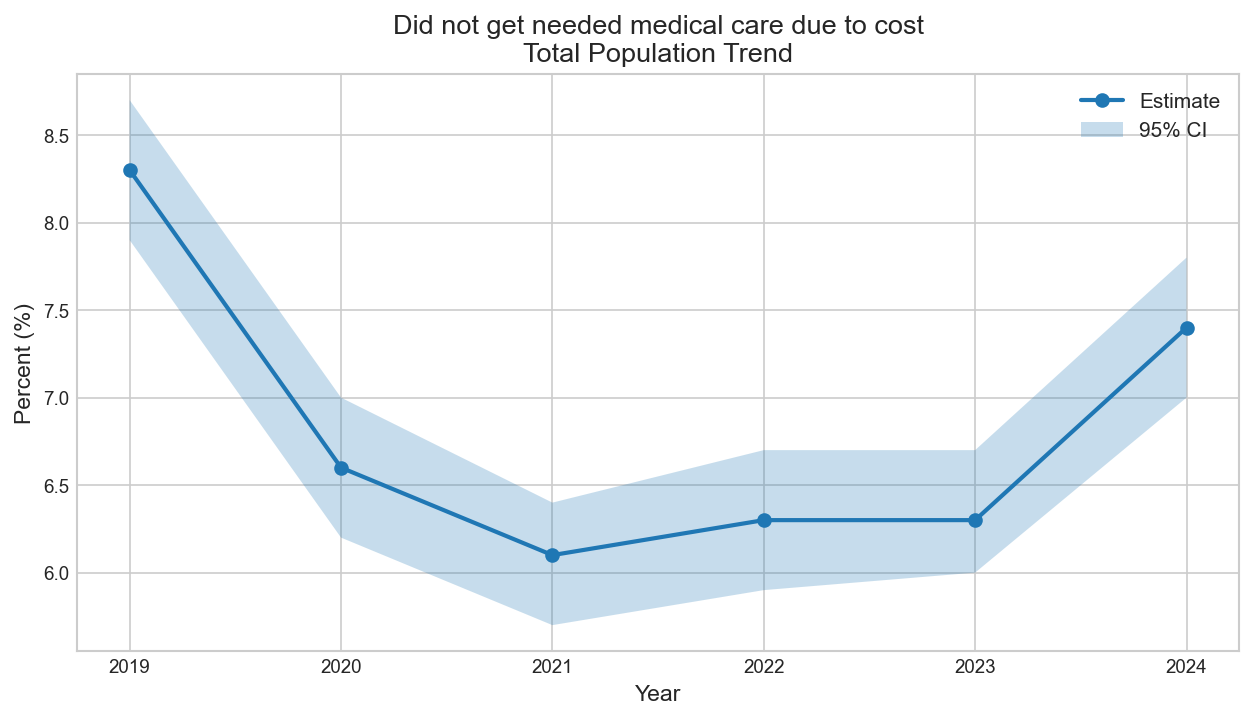

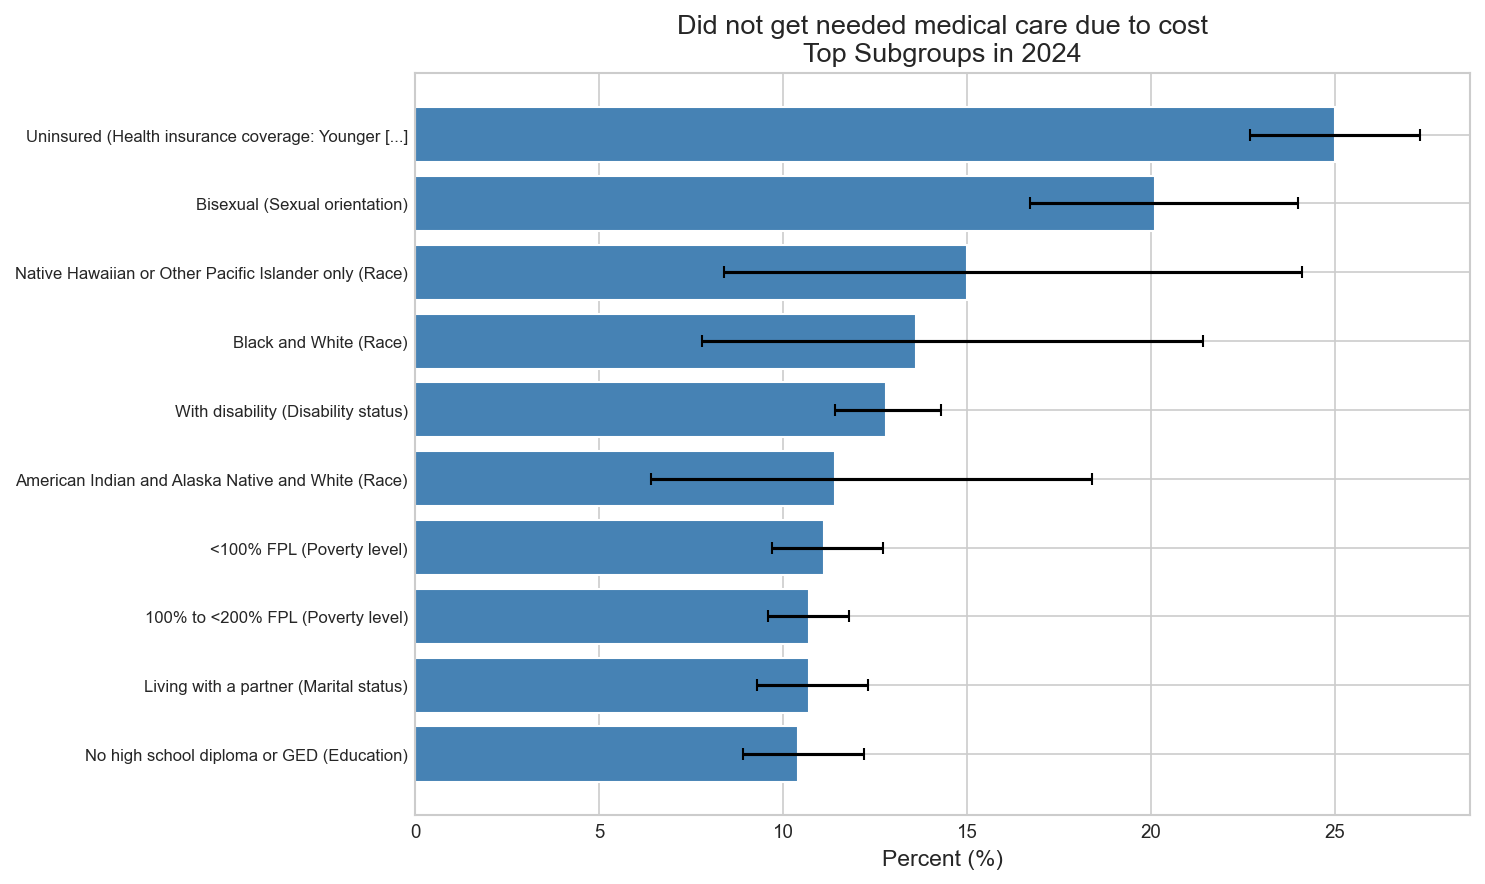

/var/folders/x2/3jft75dx3fn8xvn3p5vpdr3c0000gn/T/ipykernel_89955/2874379171.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_year, labels=[str(y) for y in years], patch_artist=True)


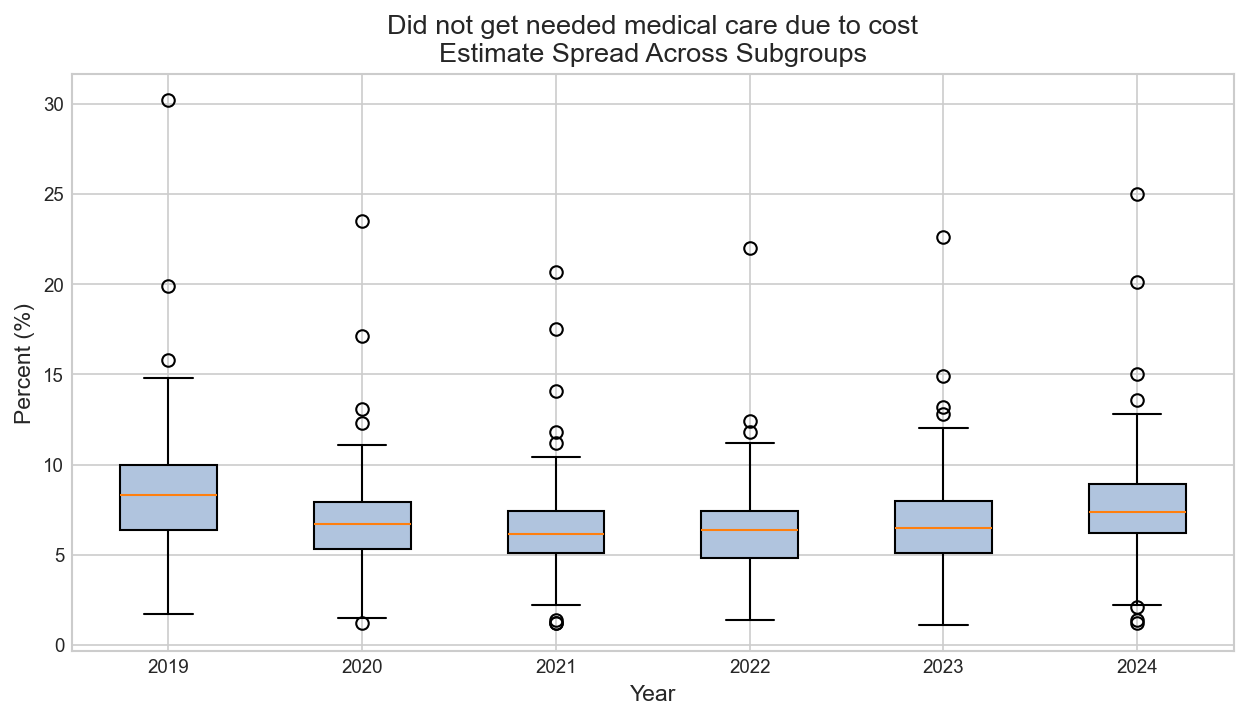


Did not take medication as prescribed to save money


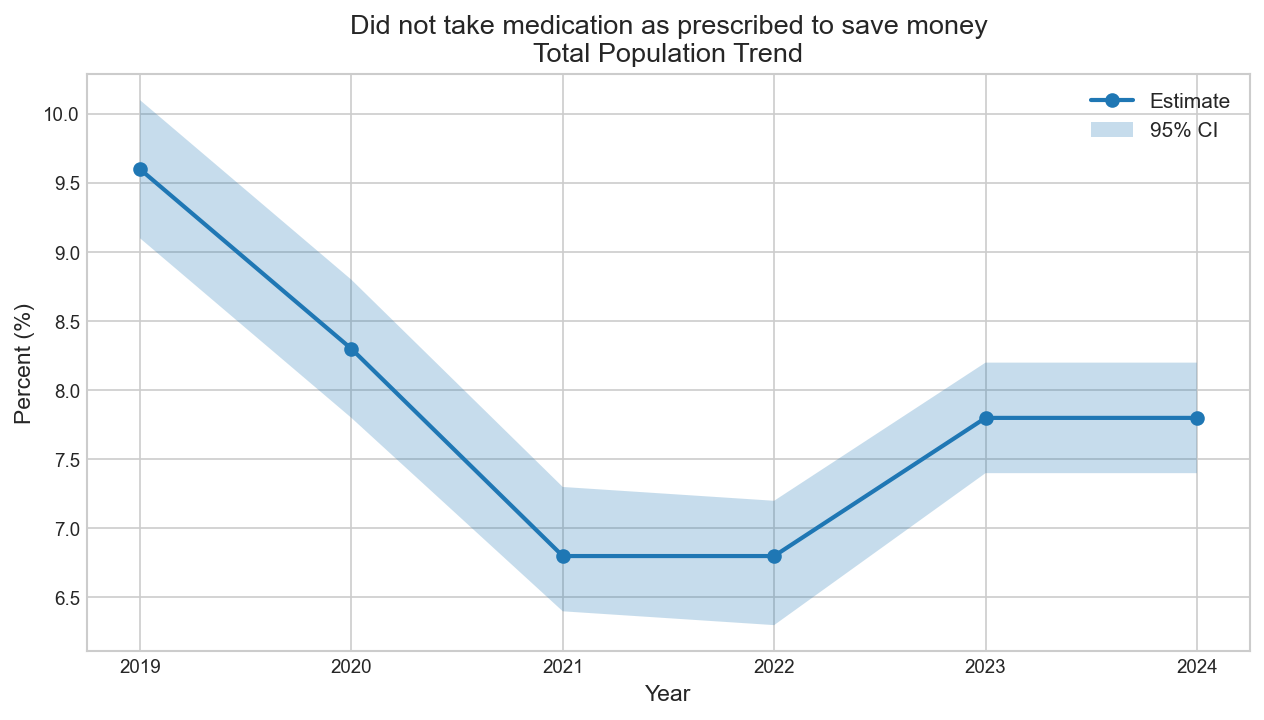

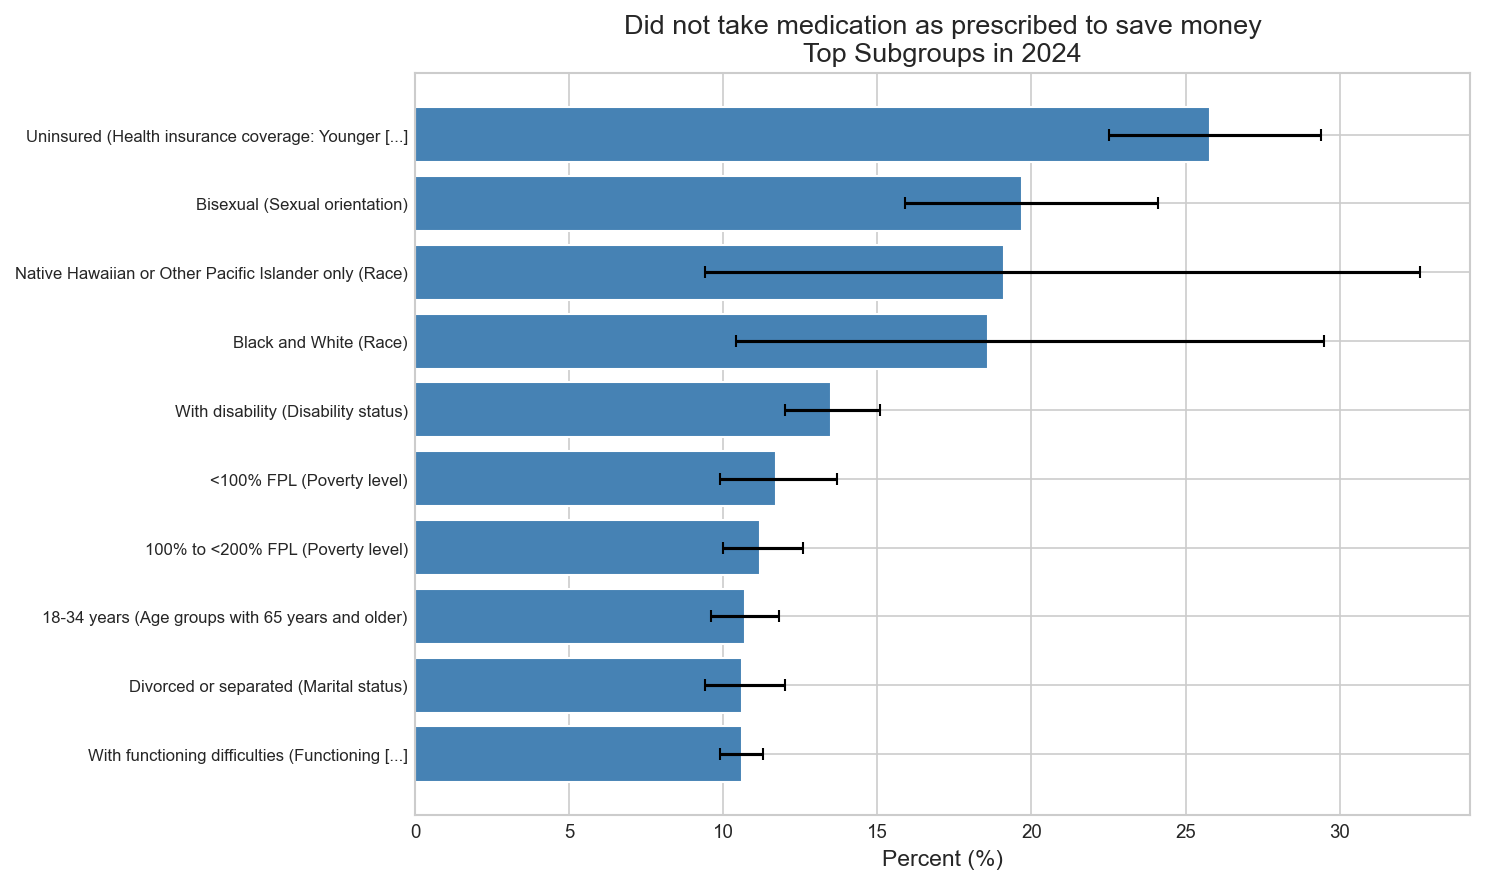

/var/folders/x2/3jft75dx3fn8xvn3p5vpdr3c0000gn/T/ipykernel_89955/2874379171.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_year, labels=[str(y) for y in years], patch_artist=True)


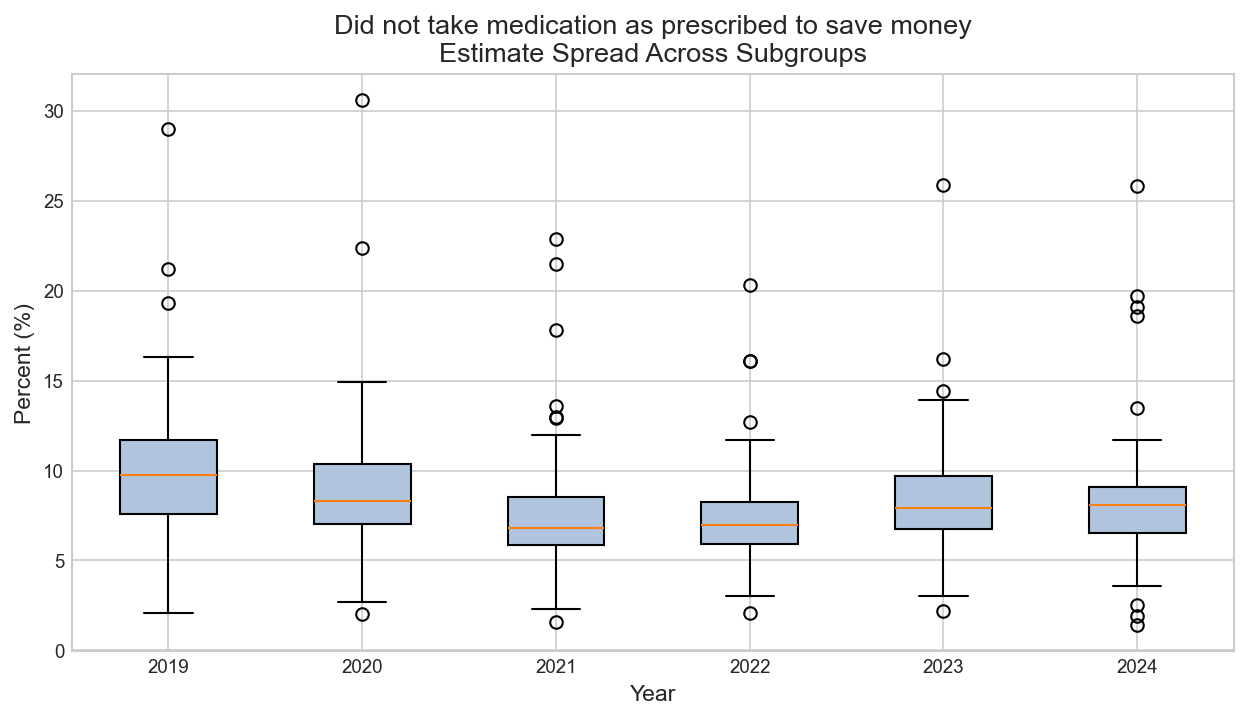

In [5]:
# ── Cell 5: Per-Measure Visualizations ────────────────────────────────────────

def _slug(topic, subtopic):
    """Create a filesystem-safe slug from topic/subtopic."""
    label = topic if pd.isna(subtopic) else f"{topic}_{subtopic}"
    return re.sub(r"[^a-z0-9]+", "_", label.lower()).strip("_")[:80]


def _measure_df(topic, subtopic, etype):
    """Filter df_access to a single measure."""
    mask = df_access["TOPIC"] == topic
    if pd.isna(subtopic):
        mask &= df_access["SUBTOPIC"].isna()
    else:
        mask &= df_access["SUBTOPIC"] == subtopic
    mask &= df_access["ESTIMATE_TYPE"] == etype
    return df_access[mask].copy()


def plot_trend(mdf, slug, title):
    """1. Total trend line with CI."""
    total = mdf[
        (mdf["CLASSIFICATION"] == "Total") &
        (mdf["SUBGROUP"].str.contains("18 years and older", case=False, na=False))
    ].sort_values("TIME_PERIOD")
    if total.empty:
        # Fallback: any Total row
        total = mdf[mdf["CLASSIFICATION"] == "Total"].sort_values("TIME_PERIOD")
    if total.empty:
        print(f"  [trend] No Total rows for {title}")
        return
    fig, ax = plt.subplots()
    ax.plot(total["TIME_PERIOD"], total["ESTIMATE"], "o-", linewidth=2, label="Estimate")
    ax.fill_between(
        total["TIME_PERIOD"], total["ESTIMATE_LCI"], total["ESTIMATE_UCI"],
        alpha=0.25, label="95% CI",
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Percent (%)")
    ax.set_title(f"{title}\nTotal Population Trend")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.legend()
    fig.savefig(FIGURES / f"{slug}_trend.png")
    plt.show()
    plt.close(fig)


def plot_top_subgroups(mdf, slug, title):
    """2. Top subgroups in latest year with CI error bars."""
    latest_year = mdf["TIME_PERIOD"].max()
    sub = mdf[
        (mdf["TIME_PERIOD"] == latest_year) &
        (mdf["CLASSIFICATION"] != "Total")
    ].copy()
    if sub.empty:
        print(f"  [subgroups] No non-Total rows for {title}")
        return
    sub = sub.sort_values("ESTIMATE", ascending=False).head(10)
    # Error bar half-widths
    sub["err_lo"] = sub["ESTIMATE"] - sub["ESTIMATE_LCI"]
    sub["err_hi"] = sub["ESTIMATE_UCI"] - sub["ESTIMATE"]

    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = range(len(sub))
    ax.barh(
        y_pos, sub["ESTIMATE"],
        xerr=[sub["err_lo"].values, sub["err_hi"].values],
        capsize=3, color="steelblue", edgecolor="white",
    )
    labels = (sub["SUBGROUP"] + "  (" + sub["GROUP"] + ")").values
    ax.set_yticks(list(y_pos))
    ax.set_yticklabels([textwrap.shorten(l, 55) for l in labels], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel("Percent (%)")
    ax.set_title(f"{title}\nTop Subgroups in {latest_year}")
    fig.tight_layout()
    fig.savefig(FIGURES / f"{slug}_subgroups.png")
    plt.show()
    plt.close(fig)


def plot_spread(mdf, slug, title):
    """3. Spread distribution — box-plots of estimates across subgroups per year."""
    sub = mdf[mdf["CLASSIFICATION"] != "Total"].copy()
    if sub.empty:
        print(f"  [spread] No non-Total rows for {title}")
        return
    years = sorted(sub["TIME_PERIOD"].dropna().unique())
    data_by_year = [sub.loc[sub["TIME_PERIOD"] == y, "ESTIMATE"].dropna().values for y in years]

    fig, ax = plt.subplots()
    bp = ax.boxplot(data_by_year, labels=[str(y) for y in years], patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_facecolor("lightsteelblue")
    ax.set_xlabel("Year")
    ax.set_ylabel("Percent (%)")
    ax.set_title(f"{title}\nEstimate Spread Across Subgroups")
    fig.savefig(FIGURES / f"{slug}_spread.png")
    plt.show()
    plt.close(fig)


# ── Generate all plots ──
for topic, subtopic, etype in selected_measures:
    slug = _slug(topic, subtopic)
    label = topic if pd.isna(subtopic) else f"{topic} / {subtopic}"
    short_title = textwrap.shorten(label, 65)
    print(f"\n{'='*70}\n{short_title}\n{'='*70}")
    mdf = _measure_df(topic, subtopic, etype)
    plot_trend(mdf, slug, short_title)
    plot_top_subgroups(mdf, slug, short_title)
    plot_spread(mdf, slug, short_title)

## Cell 6 — Composite Access Friction Score

Z-score each estimate within its `(measure, year, group_key)` cell, then average z-scores
across measures per `(SUBGROUP, TIME_PERIOD)` to create a single **friction score**.

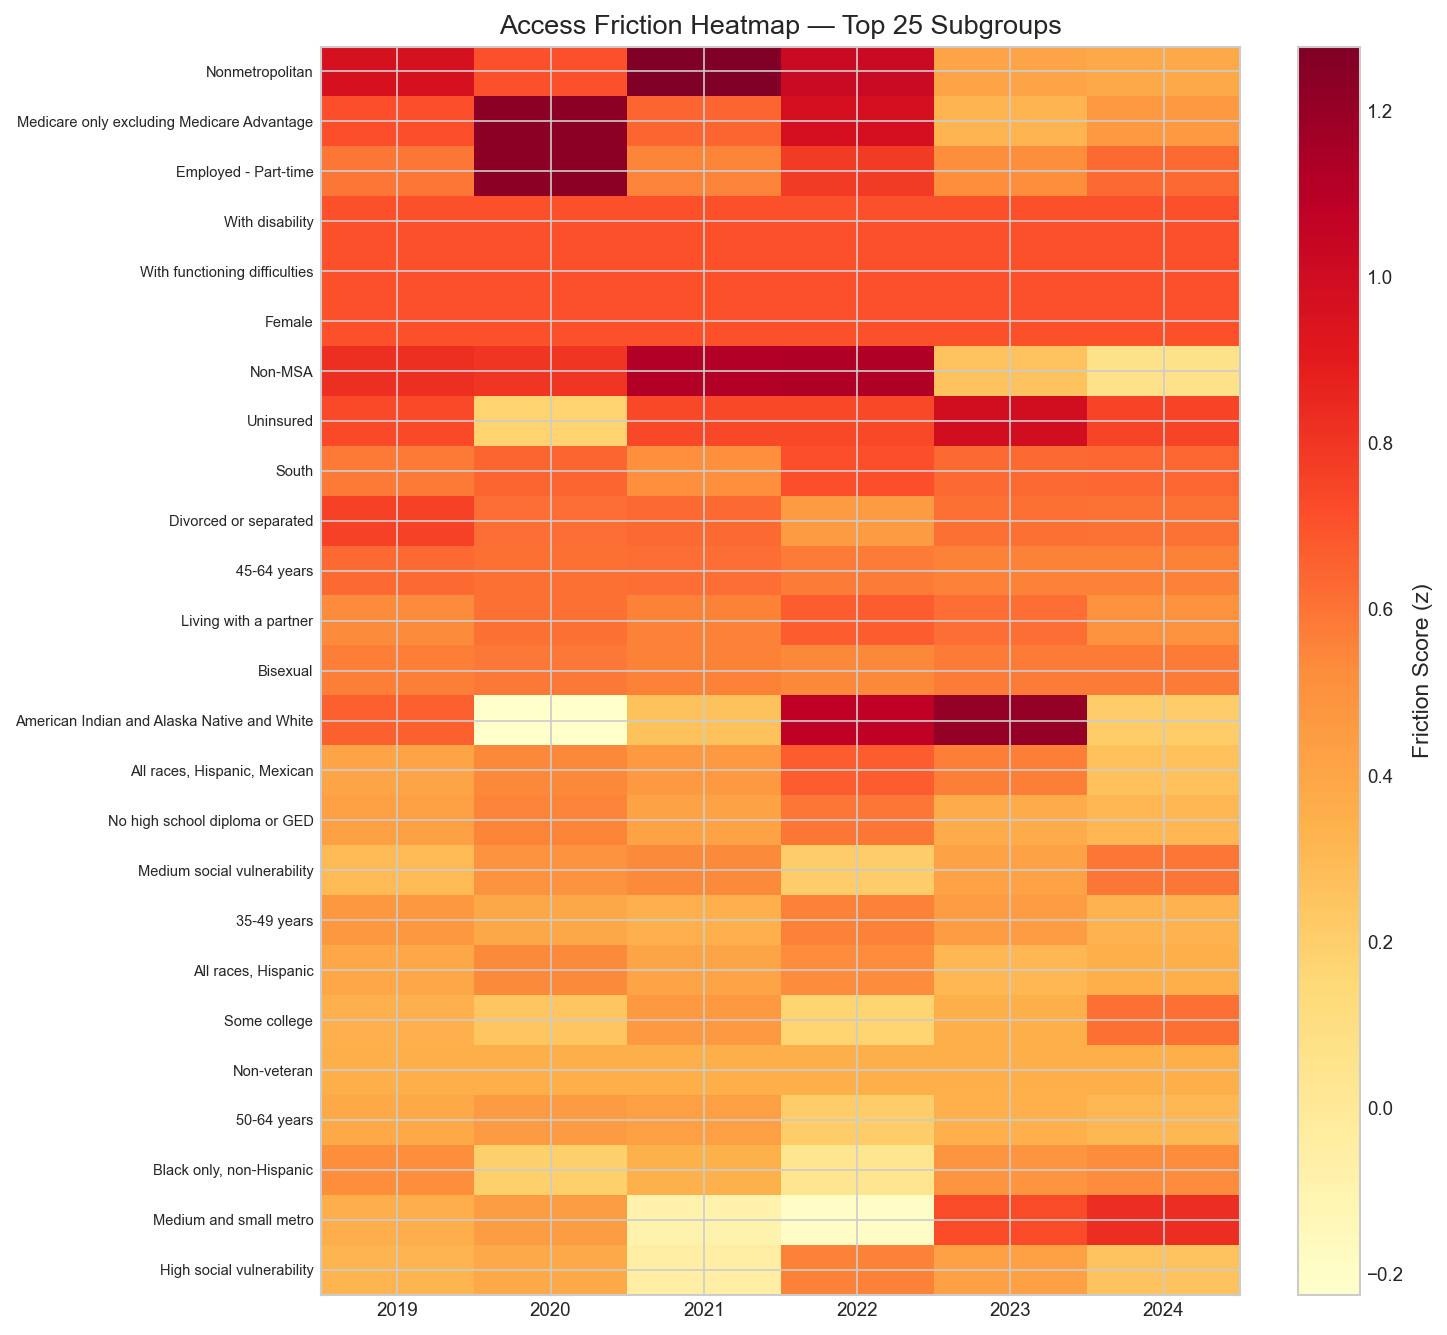


Top 15 Highest-Friction Subgroups in 2024:

                                            SUBGROUP  TIME_PERIOD  friction_score
Rank                                                                             
1                             Medium and small metro         2024        0.828501
2                                          Uninsured         2024        0.745151
3                      With functioning difficulties         2024        0.707107
4                                    With disability         2024        0.707107
5                                             Female         2024        0.707107
6                                          Small MSA         2024        0.669765
7                                              South         2024        0.641665
8                               Employed - Part-time         2024        0.631477
9     Native Hawaiian or Other Pacific Islander only         2024        0.620125
10                                      Some college 

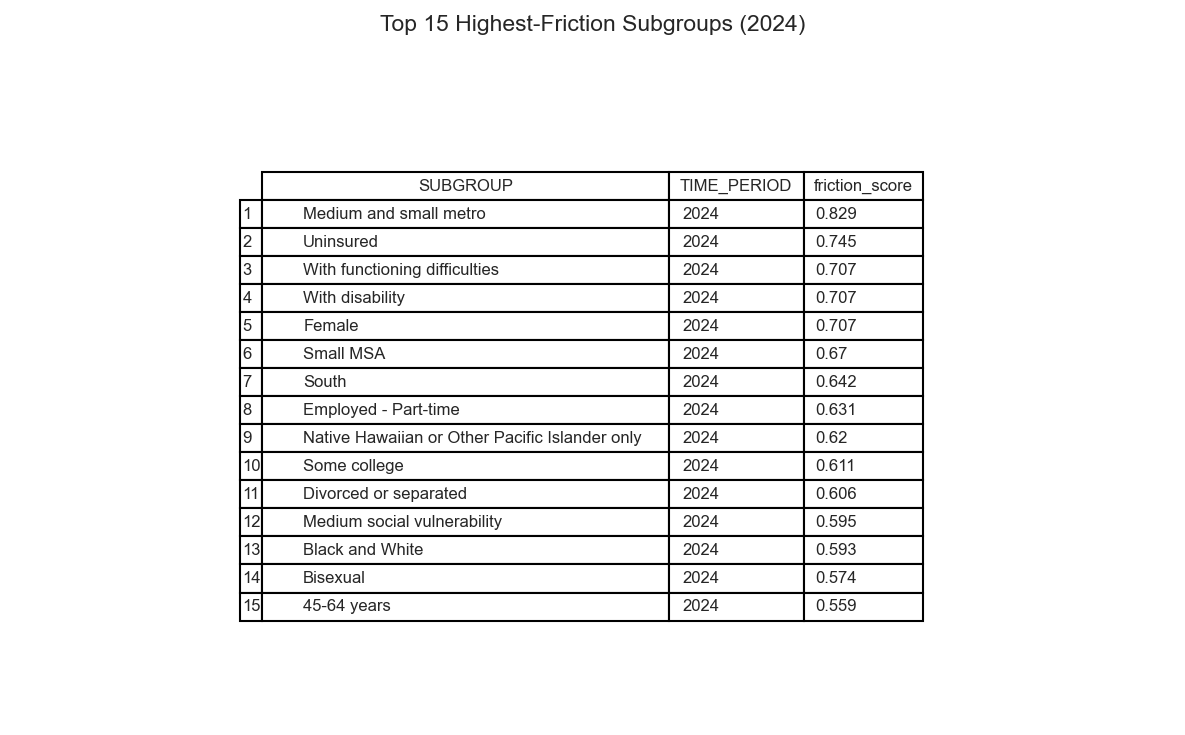

In [6]:
# ── Cell 6: Composite Access Friction Score ───────────────────────────────────

# Filter df_access to selected measures only & exclude "Total" classification
sel_mask = pd.DataFrame(selected_measures, columns=["TOPIC", "SUBTOPIC", "ESTIMATE_TYPE"])

friction_rows = []
for _, row in sel_mask.iterrows():
    mask = df_access["TOPIC"] == row["TOPIC"]
    if pd.isna(row["SUBTOPIC"]):
        mask &= df_access["SUBTOPIC"].isna()
    else:
        mask &= df_access["SUBTOPIC"] == row["SUBTOPIC"]
    mask &= df_access["ESTIMATE_TYPE"] == row["ESTIMATE_TYPE"]
    friction_rows.append(df_access[mask])

df_sel = pd.concat(friction_rows, ignore_index=True)
df_sel = df_sel[df_sel["CLASSIFICATION"] != "Total"].copy()

# Build group_key
df_sel["group_key"] = df_sel["CLASSIFICATION"].astype(str) + " | " + df_sel["GROUP"].astype(str)

# Build measure_key
df_sel["measure_key"] = df_sel["TOPIC"].astype(str)  # SUBTOPIC is mostly NaN, TOPIC suffices

# Z-score ESTIMATE within (measure_key, TIME_PERIOD, group_key)
def _zscore_series(estimates):
    mu, sigma = estimates.mean(), estimates.std()
    if sigma == 0 or np.isnan(sigma):
        return pd.Series(0.0, index=estimates.index)
    return (estimates - mu) / sigma

df_sel["z_est"] = df_sel.groupby(
    ["measure_key", "TIME_PERIOD", "group_key"]
)["ESTIMATE"].transform(_zscore_series)

# Average z-scores across measures for each (SUBGROUP, TIME_PERIOD)
friction = (
    df_sel
    .groupby(["SUBGROUP", "TIME_PERIOD"])["z_est"]
    .mean()
    .reset_index()
    .rename(columns={"z_est": "friction_score"})
)

# ── Heatmap ──────────────────────────────────────────────────────────────────
pivot = friction.pivot_table(index="SUBGROUP", columns="TIME_PERIOD", values="friction_score")

# Keep only subgroups that have data for at least 3 years and some variance
pivot = pivot.dropna(thresh=3)
# Sort by mean friction descending, keep top 25 for readability
pivot["_mean"] = pivot.mean(axis=1)
pivot = pivot.sort_values("_mean", ascending=False).head(25).drop(columns="_mean")

fig, ax = plt.subplots(figsize=(10, 9))
im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd")
ax.set_xticks(range(pivot.shape[1]))
ax.set_xticklabels([str(int(c)) for c in pivot.columns])
ax.set_yticks(range(pivot.shape[0]))
ax.set_yticklabels([textwrap.shorten(s, 50) for s in pivot.index], fontsize=7)
plt.colorbar(im, ax=ax, label="Friction Score (z)")
ax.set_title("Access Friction Heatmap — Top 25 Subgroups")
fig.tight_layout()
fig.savefig(FIGURES / "friction_heatmap.png")
plt.show()
plt.close(fig)

# ── Ranked Table (latest year) ───────────────────────────────────────────────
latest = friction["TIME_PERIOD"].max()
ranked = (
    friction[friction["TIME_PERIOD"] == latest]
    .sort_values("friction_score", ascending=False)
    .head(15)
    .reset_index(drop=True)
)
ranked.index += 1
ranked.index.name = "Rank"

print(f"\nTop 15 Highest-Friction Subgroups in {latest}:\n")
print(ranked.to_string())

# Save as figure (table rendered via matplotlib)
fig, ax = plt.subplots(figsize=(8, 5))
ax.axis("off")
tbl = ax.table(
    cellText=ranked.round(3).values,
    colLabels=ranked.columns.tolist(),
    rowLabels=ranked.index.tolist(),
    loc="center",
    cellLoc="left",
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(list(range(len(ranked.columns))))
ax.set_title(f"Top 15 Highest-Friction Subgroups ({latest})", fontsize=11, pad=20)
fig.tight_layout()
fig.savefig(FIGURES / "friction_ranked.png")
plt.show()
plt.close(fig)

## Cell 7 — Inequity Gaps Over Time

Dynamically detect subgroup pairs (age extremes, insured vs uninsured, income extremes,
male vs female) and plot the absolute gap with pooled-SE confidence intervals.

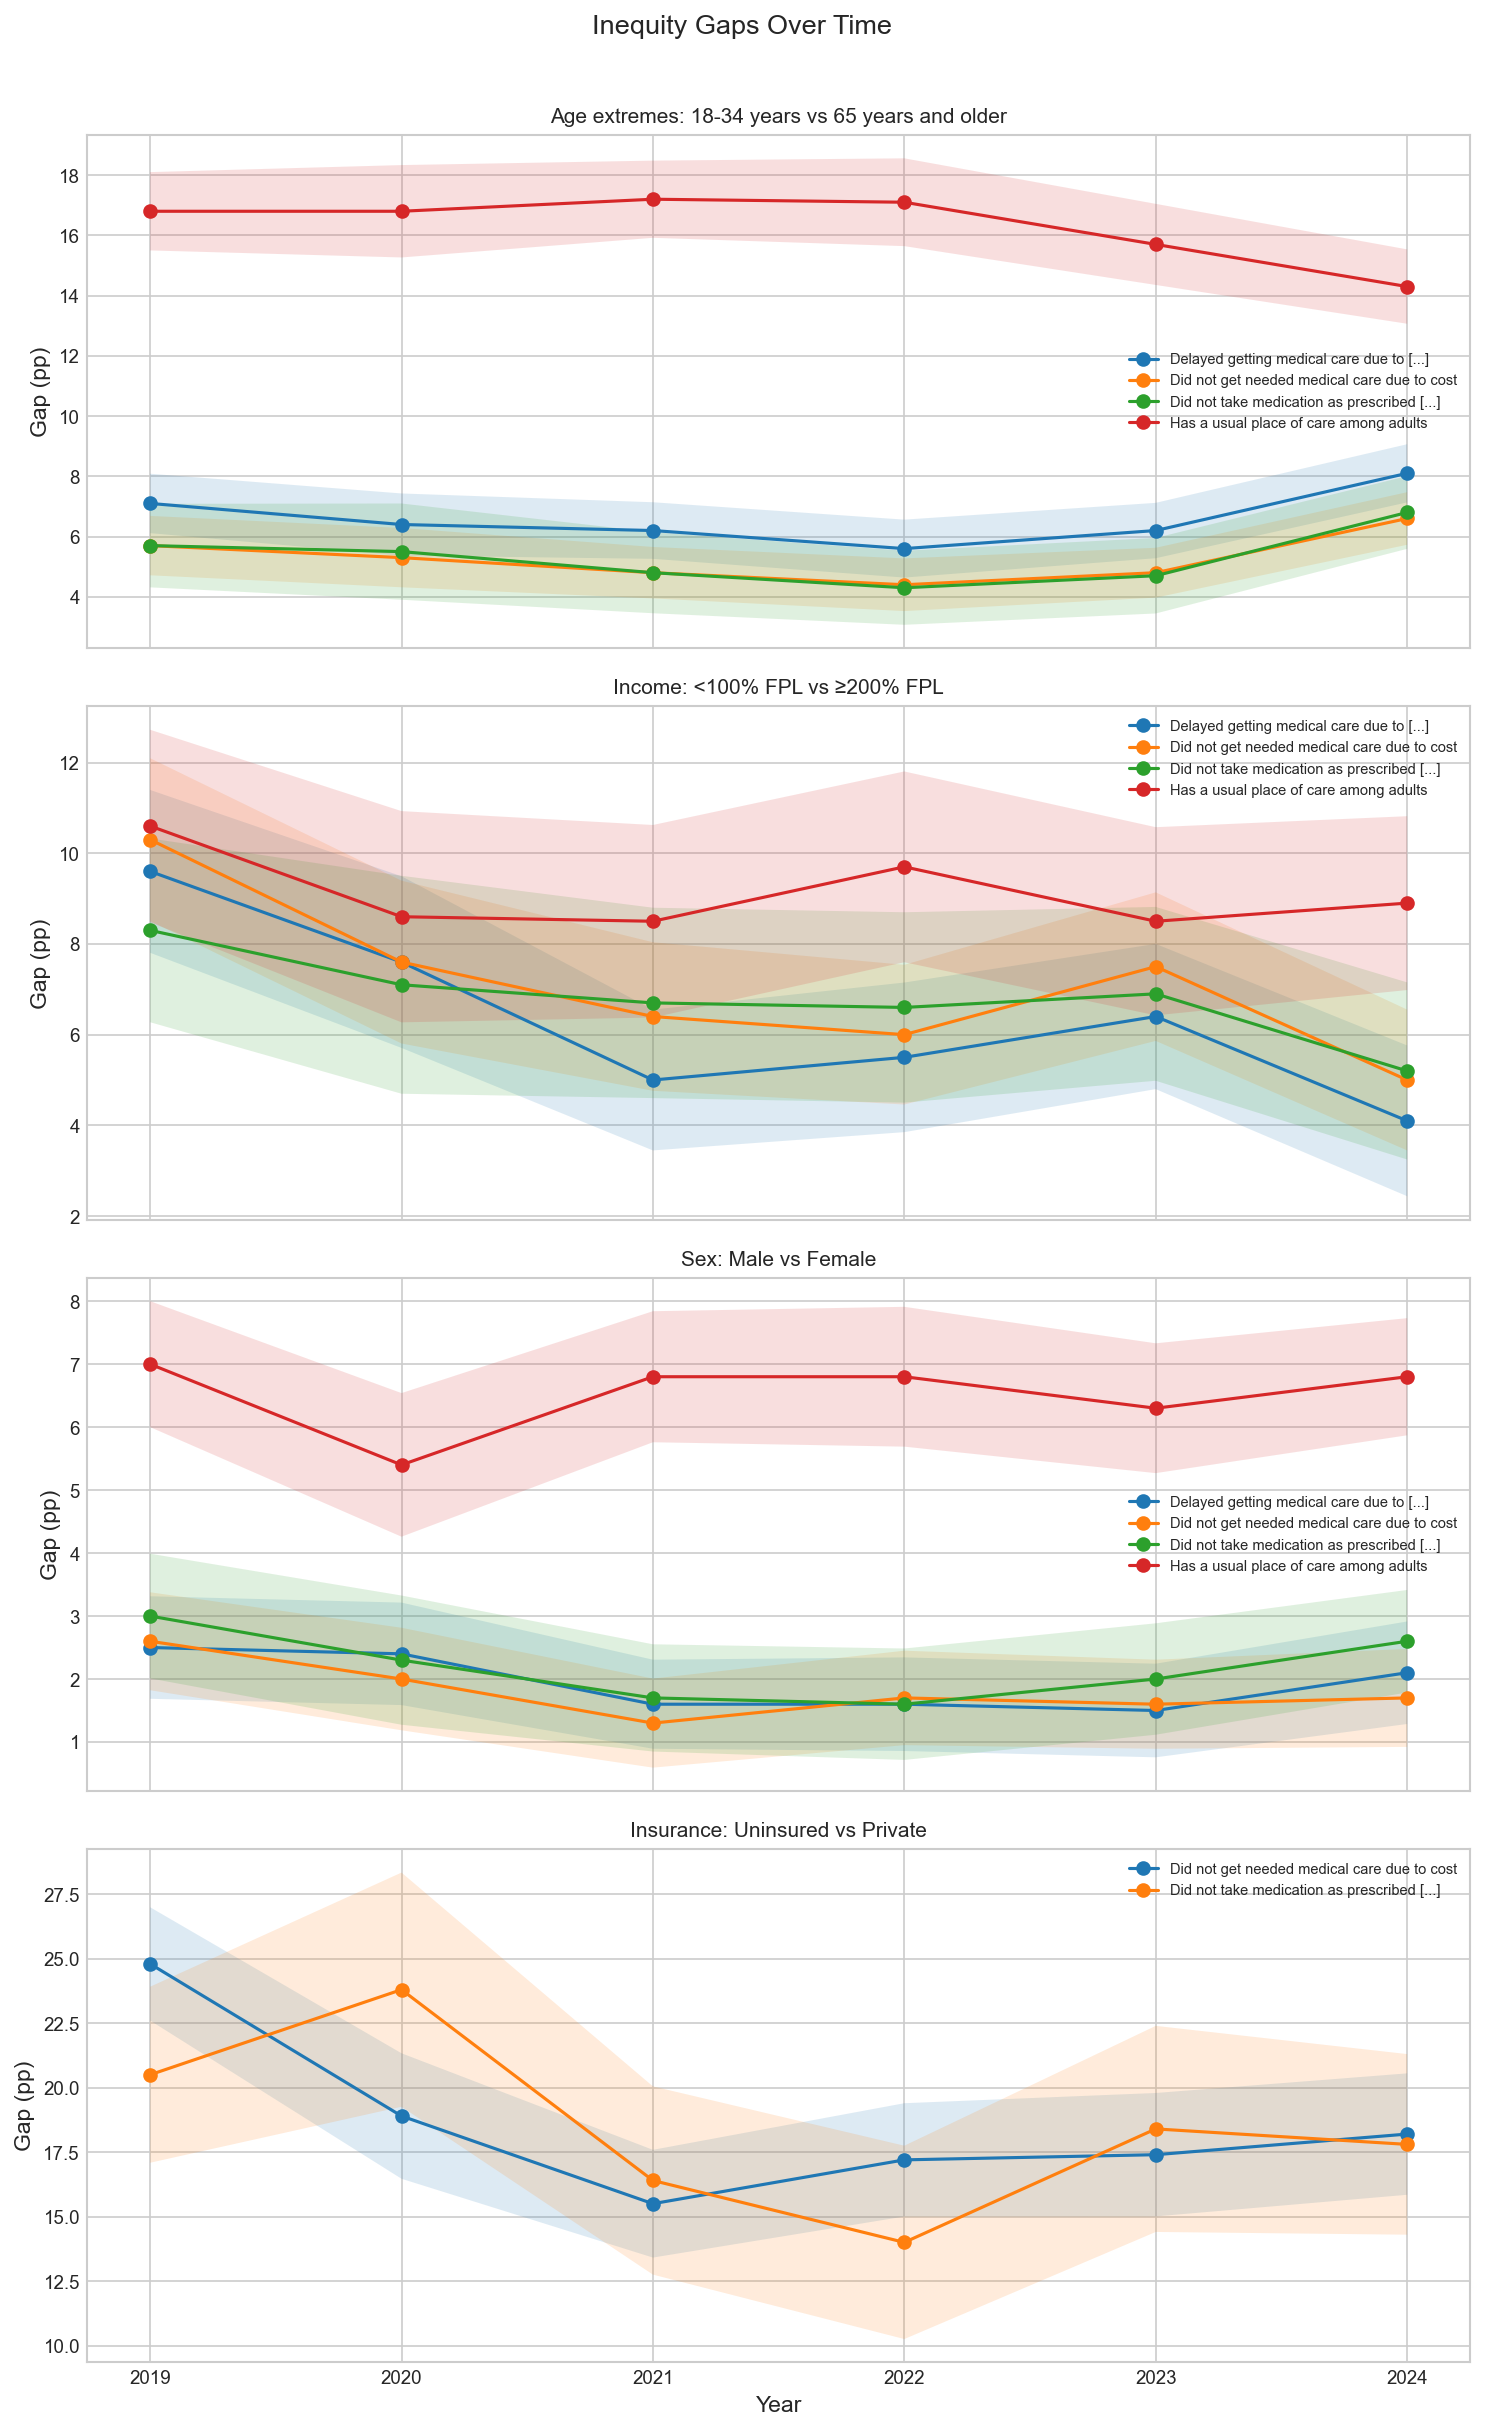


Plotted 4 gap pair(s) across 4 measure(s).


In [7]:
# ── Cell 7: Inequity Gaps Over Time ───────────────────────────────────────────

# Helper: find a subgroup value in a given GROUP that matches a regex
def _find_subgroup(df, group_pattern, subgroup_pattern):
    """Return the exact SUBGROUP string that matches, or None."""
    mask = df["GROUP"].str.contains(group_pattern, case=False, na=False)
    candidates = df.loc[mask, "SUBGROUP"].dropna().unique()
    for c in candidates:
        if re.search(subgroup_pattern, c, re.IGNORECASE):
            return c
    return None


def _detect_pairs(df):
    """Dynamically detect comparison pairs present in df."""
    pairs = []

    # 1. Age extremes — youngest vs oldest within any age-group GROUP
    age_groups = [g for g in df["GROUP"].dropna().unique() if "age" in g.lower()]
    for ag in age_groups:
        subs = df.loc[df["GROUP"] == ag, "SUBGROUP"].dropna().unique()
        # sort by the leading number
        def _age_key(s):
            m = re.search(r"(\d+)", s)
            return int(m.group(1)) if m else 999
        subs_sorted = sorted(subs, key=_age_key)
        if len(subs_sorted) >= 2:
            pairs.append(("Age extremes", ag, subs_sorted[0], subs_sorted[-1]))
            break  # one age-group pair is enough

    # 2. Insurance — look for Uninsured vs Private
    sg_unins = _find_subgroup(df, r"insurance|coverage", r"uninsured|not covered")
    sg_priv = _find_subgroup(df, r"insurance|coverage", r"^private")
    if sg_unins and sg_priv:
        grp = df.loc[df["SUBGROUP"] == sg_unins, "GROUP"].iloc[0]
        pairs.append(("Insurance", grp, sg_unins, sg_priv))

    # 3. Income — lowest vs highest FPL
    sg_low = _find_subgroup(df, r"income|poverty|FPL|earnings", r"<\s*100|less than 100|lowest")
    sg_high = _find_subgroup(df, r"income|poverty|FPL|earnings", r"400|highest|≥")
    if sg_low and sg_high:
        grp = df.loc[df["SUBGROUP"] == sg_low, "GROUP"].iloc[0]
        pairs.append(("Income", grp, sg_low, sg_high))

    # 4. Sex — Male vs Female
    sg_m = _find_subgroup(df, r"sex|gender", r"^male$")
    sg_f = _find_subgroup(df, r"sex|gender", r"^female$")
    if sg_m and sg_f:
        grp = df.loc[df["SUBGROUP"] == sg_m, "GROUP"].iloc[0]
        pairs.append(("Sex", grp, sg_m, sg_f))

    return pairs


# ── Compute & plot gaps ──────────────────────────────────────────────────────
all_gap_records = []

for topic, subtopic, etype in selected_measures:
    mdf = _measure_df(topic, subtopic, etype)
    pairs = _detect_pairs(mdf)
    if not pairs:
        continue
    for pair_label, grp, sg_a, sg_b in pairs:
        a = mdf[(mdf["GROUP"] == grp) & (mdf["SUBGROUP"] == sg_a)].set_index("TIME_PERIOD")
        b = mdf[(mdf["GROUP"] == grp) & (mdf["SUBGROUP"] == sg_b)].set_index("TIME_PERIOD")
        common_years = sorted(set(a.index) & set(b.index))
        if len(common_years) < 2:
            continue
        for yr in common_years:
            ea, eb = a.loc[yr, "ESTIMATE"], b.loc[yr, "ESTIMATE"]
            # Handle potential duplicate index by taking first
            if hasattr(ea, "__len__"):
                ea = ea.iloc[0]
            if hasattr(eb, "__len__"):
                eb = eb.iloc[0]
            se_a = a.loc[yr, "se"]
            se_b = b.loc[yr, "se"]
            if hasattr(se_a, "__len__"):
                se_a = se_a.iloc[0]
            if hasattr(se_b, "__len__"):
                se_b = se_b.iloc[0]
            gap = abs(float(ea) - float(eb))
            pooled_se = np.sqrt(float(se_a)**2 + float(se_b)**2)
            all_gap_records.append({
                "measure": topic if pd.isna(subtopic) else f"{topic} / {subtopic}",
                "pair": f"{pair_label}: {sg_a} vs {sg_b}",
                "year": yr,
                "gap": gap,
                "gap_lci": max(0, gap - 1.96 * pooled_se),
                "gap_uci": gap + 1.96 * pooled_se,
            })

df_gaps = pd.DataFrame(all_gap_records)

if df_gaps.empty:
    print("No valid inequity-gap pairs found.")
else:
    # One figure per pair type, panels per measure
    unique_pairs = df_gaps["pair"].unique()
    n_pairs = len(unique_pairs)
    fig, axes = plt.subplots(n_pairs, 1, figsize=(10, 4 * n_pairs), sharex=True, squeeze=False)

    for i, pair in enumerate(unique_pairs):
        ax = axes[i, 0]
        pdf = df_gaps[df_gaps["pair"] == pair]
        for measure, gdf in pdf.groupby("measure"):
            gdf = gdf.sort_values("year")
            short_m = textwrap.shorten(measure, 45)
            ax.plot(gdf["year"], gdf["gap"], "o-", label=short_m, linewidth=1.5)
            ax.fill_between(gdf["year"], gdf["gap_lci"], gdf["gap_uci"], alpha=0.15)
        ax.set_ylabel("Gap (pp)")
        ax.set_title(pair, fontsize=10)
        ax.legend(fontsize=7, loc="best")
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axes[-1, 0].set_xlabel("Year")
    fig.suptitle("Inequity Gaps Over Time", fontsize=13, y=1.01)
    fig.tight_layout()
    fig.savefig(FIGURES / "inequity_gaps.png")
    plt.show()
    plt.close(fig)
    print(f"\nPlotted {n_pairs} gap pair(s) across {df_gaps['measure'].nunique()} measure(s).")

## Cell 8 — Weighted Linear Regression Forecast

For each `(measure, SUBGROUP)` series with at least 5 years of data:
- Fit WLS (`weights = 1/se^2`) on all-but-last year (back-test), report MAE & interval coverage
- Refit on all years and forecast 2025 with prediction intervals

Back-test results (298 series):
  Overall MAE:         1.574 pp
  Interval coverage:   97.3%

                                                        n    MAE  coverage_pct
measure                                                                       
Delayed getting medical care due to cost among adults  74  2.114        97.297
Did not get needed medical care due to cost            75  1.764        96.000
Did not take medication as prescribed to save money    74  1.435        98.649
Has a usual place of care among adults                 75  0.989        97.333


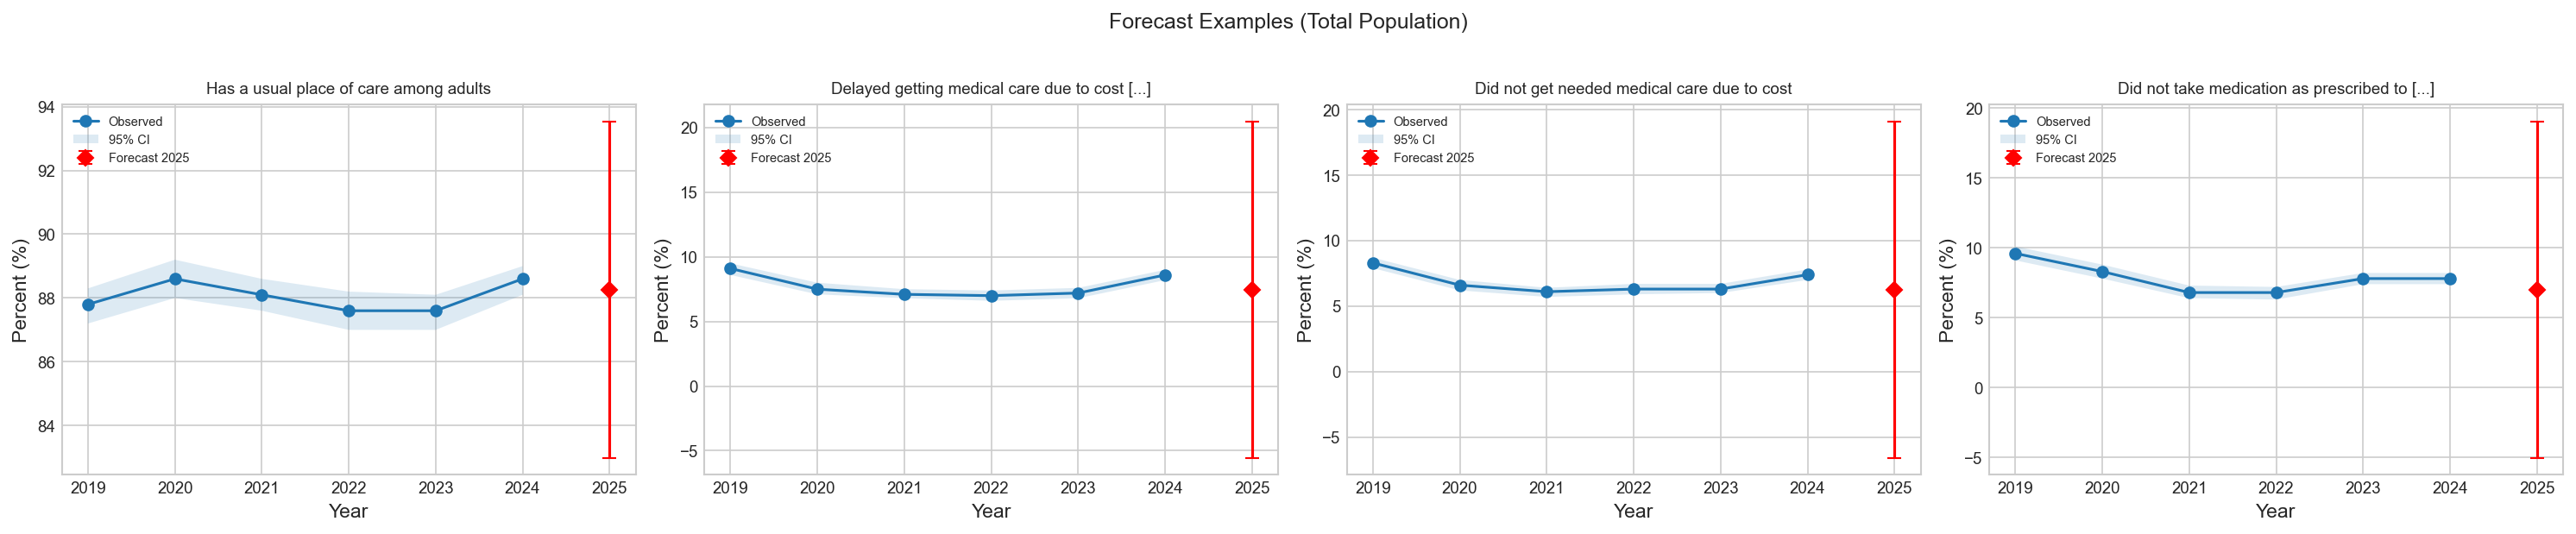


Forecast table (showing first 20 of 298 series):

                               measure                              group                             subgroup  forecast_year  forecast  forecast_lci  forecast_uci
Has a usual place of care among adults Age groups with 65 years and older                          18-34 years           2025     81.18         77.00         85.36
Has a usual place of care among adults Age groups with 65 years and older                          35-49 years           2025     85.59         80.93         90.26
Has a usual place of care among adults Age groups with 65 years and older                          50-64 years           2025     91.77         87.66         95.88
Has a usual place of care among adults Age groups with 65 years and older                   65 years and older           2025     95.79         92.74         98.83
Has a usual place of care among adults Age groups with 75 years and older                          18-44 years           2025    

In [8]:
# ── Cell 8: Weighted Linear Regression Forecast ──────────────────────────────
MIN_YEARS = 5
FORECAST_YEAR = 2025


def _prediction_interval(X_train, y_train, weights, x_new, alpha=0.05):
    """Weighted OLS with proper prediction interval using t-distribution."""
    model = LinearRegression()
    model.fit(X_train, y_train, sample_weight=weights)
    y_hat_train = model.predict(X_train)
    y_hat_new = model.predict(x_new.reshape(1, -1))[0]

    n = len(y_train)
    p = 2  # intercept + 1 feature
    resid = y_train - y_hat_train
    # Weighted residual variance (MSE)
    mse = np.sum(weights * resid ** 2) / max(n - p, 1)

    # Leverage for new point: h = 1/n + (x - x_mean)^2 / sum(w*(x - x_mean)^2)
    x_mean = np.average(X_train.ravel(), weights=weights)
    ss_x = np.sum(weights * (X_train.ravel() - x_mean) ** 2)
    h_new = 1.0 / np.sum(weights) + (x_new[0] - x_mean) ** 2 / max(ss_x, 1e-12)

    # Prediction SE includes residual + leverage uncertainty
    pred_se = np.sqrt(mse * (1 + h_new))

    # t-critical value approximation for small df (n-p)
    # For df=3: 3.182, df=4: 2.776, df=5: 2.571, df>=30: ~2.0
    df = max(n - p, 1)
    # Simple rational approximation of t_{alpha/2, df}
    if df <= 1:
        t_crit = 12.71
    elif df <= 2:
        t_crit = 4.303
    elif df <= 3:
        t_crit = 3.182
    elif df <= 4:
        t_crit = 2.776
    elif df <= 5:
        t_crit = 2.571
    elif df <= 10:
        t_crit = 2.228
    elif df <= 20:
        t_crit = 2.086
    else:
        t_crit = 1.96

    lci = y_hat_new - t_crit * pred_se
    uci = y_hat_new + t_crit * pred_se
    return model, y_hat_new, lci, uci, pred_se


backtest_results = []
forecast_results = []
plot_examples = []  # collect a few for plotting

for topic, subtopic, etype in selected_measures:
    mdf = _measure_df(topic, subtopic, etype)
    measure_label = topic if pd.isna(subtopic) else f"{topic} / {subtopic}"

    # Iterate over unique (GROUP, SUBGROUP) combinations
    for (grp, sg), sdf in mdf.groupby(["GROUP", "SUBGROUP"]):
        sdf = sdf.dropna(subset=["ESTIMATE", "se"]).sort_values("TIME_PERIOD")
        sdf = sdf[sdf["se"] > 0]  # avoid division by zero in weights
        if len(sdf) < MIN_YEARS:
            continue

        years = sdf["TIME_PERIOD"].values.astype(float)
        estimates = sdf["ESTIMATE"].values
        ses = sdf["se"].values
        weights = 1.0 / (ses ** 2)

        # ── Back-test: hold out last year ────────────────────────────────
        X_train = years[:-1].reshape(-1, 1)
        y_train = estimates[:-1]
        w_train = weights[:-1]
        x_test = years[-1:]
        y_test = estimates[-1]

        _, y_pred_bt, pred_lci, pred_uci, _ = _prediction_interval(
            X_train, y_train, w_train, x_test
        )
        covered = pred_lci <= y_test <= pred_uci

        backtest_results.append({
            "measure": measure_label,
            "group": grp,
            "subgroup": sg,
            "actual": y_test,
            "predicted": round(y_pred_bt, 2),
            "abs_error": abs(y_test - y_pred_bt),
            "covered": covered,
        })

        # ── Full-data forecast ───────────────────────────────────────────
        X_full = years.reshape(-1, 1)
        _, y_fc, fc_lci, fc_uci, _ = _prediction_interval(
            X_full, estimates, weights, np.array([FORECAST_YEAR])
        )

        forecast_results.append({
            "measure": measure_label,
            "group": grp,
            "subgroup": sg,
            "forecast_year": FORECAST_YEAR,
            "forecast": round(y_fc, 2),
            "forecast_lci": round(fc_lci, 2),
            "forecast_uci": round(fc_uci, 2),
        })

        # Collect a few examples for plotting (Total-level subgroups)
        if grp == "Total" and len(plot_examples) < 4:
            plot_examples.append({
                "label": textwrap.shorten(measure_label, 50),
                "years": years,
                "estimates": estimates,
                "lci": sdf["ESTIMATE_LCI"].values,
                "uci": sdf["ESTIMATE_UCI"].values,
                "fc_year": FORECAST_YEAR,
                "fc_est": y_fc,
                "fc_lci": fc_lci,
                "fc_uci": fc_uci,
            })

# ── Aggregate back-test metrics ──────────────────────────────────────────────
df_bt = pd.DataFrame(backtest_results)
if not df_bt.empty:
    overall_mae = df_bt["abs_error"].mean()
    coverage = df_bt["covered"].mean() * 100
    print(f"Back-test results ({len(df_bt)} series):")
    print(f"  Overall MAE:         {overall_mae:.3f} pp")
    print(f"  Interval coverage:   {coverage:.1f}%\n")

    # Per-measure summary
    bt_summary = df_bt.groupby("measure").agg(
        n=("abs_error", "size"),
        MAE=("abs_error", "mean"),
        coverage_pct=("covered", lambda x: x.mean() * 100),
    ).round(3)
    print(bt_summary.to_string())
else:
    print("No series qualified for back-testing.")

# ── Plot forecast examples ───────────────────────────────────────────────────
if plot_examples:
    n = len(plot_examples)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False)
    for i, ex in enumerate(plot_examples):
        ax = axes[0, i]
        ax.plot(ex["years"], ex["estimates"], "o-", label="Observed")
        ax.fill_between(ex["years"], ex["lci"], ex["uci"], alpha=0.15, label="95% CI")
        ax.errorbar(
            ex["fc_year"], ex["fc_est"],
            yerr=[[ex["fc_est"] - ex["fc_lci"]], [ex["fc_uci"] - ex["fc_est"]]],
            fmt="D", color="red", capsize=4, label=f"Forecast {ex['fc_year']}",
        )
        ax.set_title(ex["label"], fontsize=9)
        ax.set_xlabel("Year")
        ax.set_ylabel("Percent (%)")
        ax.legend(fontsize=7)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    fig.suptitle("Forecast Examples (Total Population)", fontsize=12, y=1.02)
    fig.tight_layout()
    fig.savefig(FIGURES / "forecast_examples.png")
    plt.show()
    plt.close(fig)

# ── Forecast table (first 20 rows) ──────────────────────────────────────────
df_fc = pd.DataFrame(forecast_results)
if not df_fc.empty:
    print(f"\nForecast table (showing first 20 of {len(df_fc)} series):\n")
    print(df_fc.head(20).to_string(index=False))

## Cell 9 — Generate Submission Report

In [9]:
# ── Cell 9: Generate Submission Report ────────────────────────────────────────

# Collect dynamic content for the report
_measure_bullets = "\n".join(
    f"- **{t if pd.isna(s) else t + ' / ' + s}** ({e})"
    for t, s, e in selected_measures
)

_bt_text = ""
if not df_bt.empty:
    _bt_text = (
        f"Back-test on {len(df_bt)} series (hold-out-last-year):\n"
        f"- **MAE**: {df_bt['abs_error'].mean():.3f} percentage points\n"
        f"- **95 % prediction-interval coverage**: {df_bt['covered'].mean()*100:.1f} %\n"
    )
else:
    _bt_text = "Insufficient data for back-testing.\n"

_ranked_md = ""
if not ranked.empty:
    _ranked_md = ranked.to_markdown()
else:
    _ranked_md = "_No friction data available._"

_gap_pairs_text = ""
if not df_gaps.empty:
    for pair in df_gaps["pair"].unique():
        _gap_pairs_text += f"- {pair}\n"
else:
    _gap_pairs_text = "No subgroup pairs detected.\n"

report_md = f"""\
# NHIS Access-to-Care Analysis — Submission Report

## 1. Overview

This analysis examines the CDC National Health Interview Survey (NHIS) Adult Summary
Health Statistics dataset (2019-2024) to identify barriers, inequities, and trends in
healthcare access among U.S. adults aged 18 and older.

## 2. Methods

### 2.1 Preprocessing

1. Loaded {len(df_all)} rows from `Access_to_Care_Dataset.csv`.
2. Normalized string columns (strip whitespace) and coerced numeric fields.
3. Created three tiers:
   - `df_all` ({len(df_all)} rows) — all records
   - `df_numeric` ({len(df_numeric)} rows) — non-null ESTIMATE
   - `df_clean` ({len(df_clean)} rows) — non-null ESTIMATE **and** uncertainty (CI or SE); flagged rows excluded
4. Derived standard error from confidence intervals: `se = (UCI − LCI) / (2 × 1.96)`
   since the STANDARD_ERROR column is empty for all rows in this dataset.

### 2.2 Classification

Rows were classified as **access_barrier** or **condition_prevalence** via case-insensitive
keyword search over `TOPIC + SUBTOPIC + TAXONOMY + ESTIMATE_TYPE`. Keywords:
`delay`, `did not get`, `unmet`, `cost`, `afford`, `uninsured`, `usual place of care`,
`Healthcare access and quality`, `Health insurance`.

### 2.3 Selected Access Measures

{_measure_bullets}

### 2.4 Composite Access Friction Score

For each selected measure, year, and demographic group:
1. Z-scored ESTIMATE values within `(measure, year, CLASSIFICATION | GROUP)`.
2. Averaged z-scores across measures per `(SUBGROUP, year)`.
Higher friction → subgroup experiences disproportionately worse access.

### 2.5 Inequity Gaps

Dynamically detected subgroup pairs:
{_gap_pairs_text}
For each pair, computed absolute gap per year with pooled-SE confidence intervals.

### 2.6 Forecasting

Weighted linear regression (`weights = 1/se²`) on series with ≥ {MIN_YEARS} years.

{_bt_text}

## 3. Key Findings

### 3.1 Top Friction Subgroups (Latest Year)

{_ranked_md}

### 3.2 Trend Highlights

- Per-measure trend plots are saved in `figures/` showing national-level trajectories.
- Box-plots reveal year-over-year dispersion across demographic subgroups.

### 3.3 Inequity Gaps

- Gap plots in `figures/inequity_gaps.png` show how disparities between advantaged
  and disadvantaged subgroups evolve from 2019 to 2024.

### 3.4 Forecasts

- Forecast examples for total-population series are in `figures/forecast_examples.png`.

## 4. Limitations

1. **Derived SE**: All standard errors are back-calculated from 95 % CIs; this may
   slightly differ from the survey-design-based SE.
2. **Short time series**: Only 6 years (2019-2024) limits trend reliability and
   forecast precision.
3. **Crude estimates**: The dataset provides unadjusted ("crude") percentages; age-
   adjusted comparisons may differ.
4. **Survey design effects**: NHIS uses a complex sample design; aggregated estimates
   may not capture within-stratum variability.
5. **FLAG column**: Only a small number of rows carried data-quality flags and were
   excluded; the vast majority of estimates are unflagged.
6. **Linear model assumption**: Forecasts assume linear trends, which may not hold for
   structural changes (e.g., policy shifts, pandemics).

## 5. Figures

All figures are saved to the `figures/` directory:
- `*_trend.png` — total population trend lines with CI
- `*_subgroups.png` — top subgroup bar charts
- `*_spread.png` — estimate-spread box plots
- `friction_heatmap.png` — composite friction heatmap
- `friction_ranked.png` — ranked friction table
- `inequity_gaps.png` — gap trends over time
- `forecast_examples.png` — forecast examples with prediction intervals
"""

report_path = REPORT / "submission.md"
report_path.write_text(report_md, encoding="utf-8")
print(f"Report written to {report_path} ({len(report_md)} chars)")
print("Done!")

Report written to report/submission.md (5739 chars)
Done!
